# Working With The CIFAR10 Dataset

This is it. You've seen how to define a simple convolutional neural network, compute loss w.r.t. the graph Variables, and make gradient updates manually and with `torch.nn.optim` package.
Now you might be thinking:

### What about the data?

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a `torch.*Tensor`.

- For images, packages such as `Pillow`, `OpenCV` are useful.
- For audio, packages such as `scipy` and `librosa`.
- For text, either raw Python or Cython based loading, or `NLTK` and `SpaCy` are useful.

Specifically for [Computer vision](), the creators of pytorch have generously created a package called `torchvision`, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`. This provides a huge convinence from writing boiler plate code.

We will use the **CIFAR10 dataset**. It has the classes: *‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’*. The images in CIFAR-10 are of size `3x32x32`, i.e. 3-channel color images of `32x32` pixels in size.

![CIFAR10 Dataset](../images/cifar10.png)

### Training an image classifier

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using `torchvision`.
2. Define a Convolution Neural Network.
3. Define a loss function.
4. Train the network on the training data.
5. Test the network on the test data.

#### 1. Loading and normalizing CIFAR10
Using `torchvision`, it’s extremely easy to load CIFAR10.

In [1]:
%matplotlib inline

# file manipulation
import os.path

# arrays and visualization
import numpy as np
import matplotlib.pyplot as plt

# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

# Special package provided by pytorch
import torchvision
import torchvision.transforms as transforms

Let's define some *Hyperparameters* we're gonna need later on.

In [2]:
# download parameters
data_dir = '../datasets'

# Don't download if data already exists
download = not os.path.exists(os.path.join(data_dir, 'cifar-10-batches-py'))

# class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Image channels 3 = RGB; 1 = Grayscale image.
img_channels = 3

# Training parameters
batch_size = 4    # Mini-batch size
epochs = 10       # No of passes over the training data
lr = 1e-2         # Learning rate used by optimizer

The output of the `torchvision` dataset are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

Define the data directory, i.e. where the data should be downloaded to. With the use of `os.path` module.

**NOTE:** `data_dir` could be modified to fit your use.

In [3]:
# Transform rule => Convert to a torch.Tensor and normalize the data
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), 
                                                     (0.5, 0.5, 0.5))])
# Transform rule => Convert to torch.Tensor only
# transform = transforms.Compose([transforms.ToTensor()])

# Download the dataset and apply the above transform rule.
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, 
                                        download=download, transform=transform)
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, 
                                       download=download, transform=transform)

# Dataset loaders: split into mini-batches, shuffle, etc.
trainset = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Labels: bird car horse deer


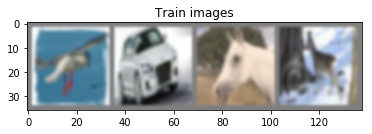

In [4]:
# Let's visualize the data
# Helper function to visualize data.
def imshow(img, title=None, smooth=False):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()
    smooth = 'bicubic' if smooth else 'spline16'
    plt.title(title if title else 'Image(s)')
    plt.imshow(np.transpose(np_img, (1, 2, 0)), interpolation=smooth)

# Get random training images
train_iter = iter(trainset)
images, labels = train_iter.next()

# show images
imshow(torchvision.utils.make_grid(images), title='Train images', smooth=True)

# print labels
print('Labels: {}'.format(' '.join(classes[l] for l in labels)))

### 2. Define a Convolution Neural Network

It's time to define our neural network. You've already seen how to define a simple convolutional neural network in the last section. But this time, instead of a single color channel, we have 3-color channels, because the CIFAR10 dataset contains colored images.

In [5]:
class Network(nn.Module):
    
    def __init__(self, **kwargs):
        super(Network, self).__init__()
        
        # Hyper-parameters
        self._img_channels = kwargs.get('img_channels', 3)
        self._num_classes = kwargs.get('num_classes', 10)
        
        # 2 convolutional & 3 fully connected layers
        self.conv1 = nn.Conv2d(self._img_channels, 16, 2)
        self.conv2 = nn.Conv2d(16, 32, 2)
        flatten_size = self.conv2.out_channels * 7 * 7
        self.fc1 = nn.Linear(flatten_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, self._num_classes)
    
    def forward(self, x):
        # Convolutional layers
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # Flatten layer
        x = x.view(-1, self._flatten(x))
        # Fully connected layers
        x = F.relu(self.fc1(x))     # relu + linear
        x = F.dropout(x, p=0.2)     # 20% dropout
        x = F.relu(self.fc2(x))     # relu + linear
        # Output layer
        x = self.fc3(x)             #  linear
        return x
    
    def _flatten(self, x):
        size = x.size()[1:]  # input shape excluding batch dim.
        return torch.Tensor(size).numel()

In [6]:
# Instantiate the network and pass in our parameters
net = Network(img_channels=img_channels, num_classes=len(classes))

### 3. Define a Loss function and optimizer

Let’s use a Classification Cross-Entropy loss and Adam optimizer.

In [7]:
# Loss function criterion
loss_func = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=lr)

### 4. Train the Network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize it.

In [8]:
for epoch in range(epochs):  # loop over the data multiple times

    # loop through the training dataset (batch by batch)
    for i, data in enumerate(trainset, 0):
        # get the inputs and labels
        inputs, labels = data
        # wrap them in Variable (explain in section 2.)
        inputs, labels = Variable(inputs), Variable(labels)
        
        # zero the optimizer gradient buffer
        # to prevent gradient accumulation.
        optimizer.zero_grad()
        
        # forward + backward + optimizer
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        print(f'\rEpoch: {epoch+1:,}\tIter: {i+1:,}\tLoss: {loss.data[0]:.4f}', end='')
    print()  # line break


print('\nFinished training!')

Epoch: 1	Iter: 12,500	Loss: 2.6687
Epoch: 2	Iter: 12,500	Loss: 1.7077
Epoch: 3	Iter: 12,500	Loss: 1.9553
Epoch: 4	Iter: 12,500	Loss: 1.8634
Epoch: 5	Iter: 12,500	Loss: 1.7319
Epoch: 6	Iter: 12,500	Loss: 1.5076
Epoch: 7	Iter: 12,500	Loss: 1.9436
Epoch: 8	Iter: 12,500	Loss: 1.9391
Epoch: 9	Iter: 12,500	Loss: 1.8468
Epoch: 10	Iter: 12,500	Loss: 2.0036

Finished training!


### 5. Test the network on the test data

We have trained the network for 5 epochs (passes over the training data). Let's check if the network has learnt anything.

How we check this is by comparing the ground-truth labels over the one the network predicted. We'll keep track of the ones predicted correctly by creating a list, and appending to the list if the prediction was the same as the ground-truth.

Alright, that been said, let's familarize ourselves with the data one more time by plotting a few from the `testset`.

Ground-struth: cat ship ship plane


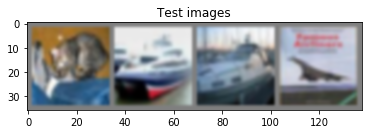

In [9]:
# Iterate through the testset.
test_iter = iter(testset)
# Store each batch in the respective variables.
images, labels = test_iter.next()

# Plot a few images.
imshow(torchvision.utils.make_grid(images), title='Test images', smooth=True)
# Class labels.
print('Ground-struth: {}'.format(' '.join([classes[l] for l in labels])))

Okay, now let's make some predictions with our network.

In [10]:
# Making predictions after training.
outputs = net(Variable(images))
print(outputs)

Variable containing:
-3.2395 -3.8604 -2.9488 -2.7225 -3.8583 -3.1245 -3.9941 -4.2793 -2.9805 -3.8941
-0.8392 -0.2896 -4.8172 -4.0310 -4.6412 -5.4577 -7.2688 -4.3122 -0.6125 -0.9047
-1.0954 -1.5840 -4.3532 -3.9535 -4.1942 -5.1947 -6.7580 -4.2483 -0.9030 -1.8089
-1.5375 -3.0679 -2.2697 -2.4028 -2.2224 -2.8639 -3.7106 -2.5395 -1.4623 -2.5937
[torch.FloatTensor of size 4x10]



The outputs are "energies" for the 10 classes. *Higher the energy for a class, the more the network thinks that the image is of the particular class*. So, let’s get the index of the highest energy:

In [11]:
# torch.max returns a tuple: (value, index)
_, predicted = torch.max(outputs.data, dim=1)

print('Prediction: {}'.format(' '.join([classes[p] for p in predicted])))

Prediction: cat car ship ship


Maybe not so bad, huh? Let's see how the result performs on the entire dataset.

In [12]:
# Keep track of correct prediction and total.
correct, total = 0, 0

# Looping through the testset.
for data in testset:
    # Unpack the images and labels
    # from each mini-batch
    images, labels = data
    # Pass image through the network
    # to make predictions.
    outputs = net(Variable(images))
    # Pretrieve the index with maximum score
    _, pred = torch.max(outputs.data, dim=1)
    # Get the batch size and add on to the total
    total += labels.size(0)
    # Count the number of correct predictions.
    # pred == outputs means where the predictions
    # equals to the ground-truth.
    correct += (pred == labels).sum()

print('Accuracy on testset = {:.2%}'.format(correct/total))

Accuracy on testset = 25.08%


Well, that's slightly better than random guessing, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [13]:
correct_class = torch.zeros(10)
total_class = torch.zeros(10)

for data in testset:
    images, labels = data
    outputs = net(Variable(images))
    _, pred = torch.max(outputs.data, dim=1)
    correct = (pred == labels).squeeze()
    
    for i, label in enumerate(labels):
        correct_class[label] += correct[i]
        total_class[label] += 1

# Calculate accuracy and sort in descending order
accuracy = correct_class / total_class
accuracy, _ = torch.sort(accuracy, descending=True)

for i, acc in enumerate(accuracy):
    print(f'Accuracy of {classes[i]} \t = {acc:.2%}')

Accuracy of plane 	 = 69.10%
Accuracy of car 	 = 52.20%
Accuracy of bird 	 = 49.20%
Accuracy of cat 	 = 47.40%
Accuracy of deer 	 = 11.40%
Accuracy of dog 	 = 9.90%
Accuracy of frog 	 = 8.20%
Accuracy of horse 	 = 2.20%
Accuracy of ship 	 = 1.10%
Accuracy of truck 	 = 0.10%
